In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 200 #resolution

#Data specification
LABELS = ["BH_n5_M8", "SPH_9"]
TRAIN_FILENAMES = [f"BH_n5_M8_res{RES}_10000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_10000_events.h5"]
TEST_FILENAMES = [f"BH_n5_M8_res{RES}_3000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_3000_events.h5"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
TRAIN_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/training/{RES}/") #The path to the folder containing the training histogram files
TEST_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/testing/{RES}/") #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1)
    )
transforms=None

resnet_1668170135
Running on the GPU


In [4]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, device, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, device, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet
train_data = Hdf5Dataset(TRAIN_DATAPATH, ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n5_M8"], device, 
                        shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)
test_data = Hdf5Dataset(TEST_DATAPATH, ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n5_M8"], device, 
                        shuffle=False, transform=None, event_limit=TEST_N_EVENTS)


#print(torch.cuda.memory_summary(device=None, abbreviated=False))

[['BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8', 'BH_n5_M8'], ['SPH_9', 'SPH_9', 'SPH_9', 'SPH_9']]
[[0, 0, 0, 0], [1, 1, 1, 1]]
[[5, 68, 62, 52], [10027, 10083, 10088, 10044]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape:  (200, 200, 3)


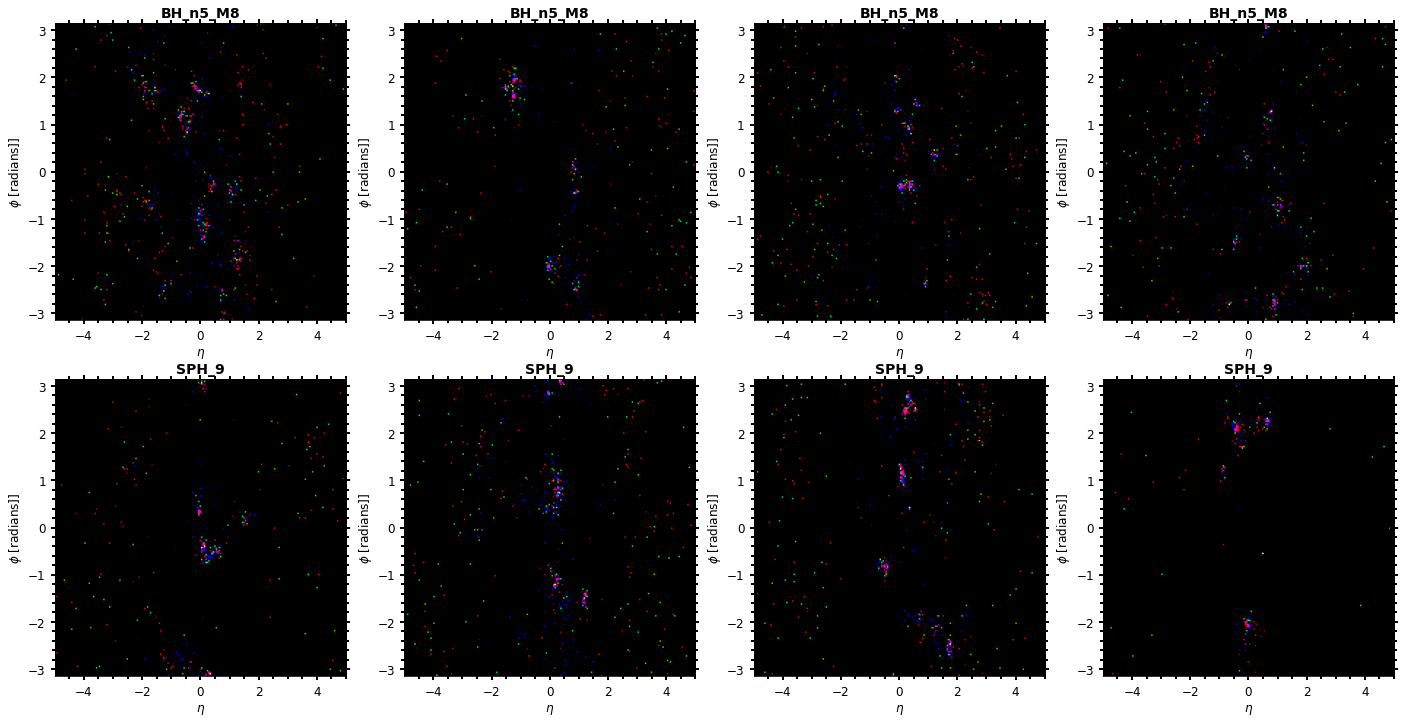

In [5]:
def view_data(data, cols, num_classes:int, labels, res,spread):
    
    def matrix_image_plot(ax, label):
        ax.set_ylabel(r"$\phi$ [radians]]", fontsize=12)
        ax.set_xlabel(r"$\eta$", fontsize=12)
        ax.set_title(label, fontsize=14,weight="bold")
        ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=12, pad=5, length=4, width=2)
        ax.tick_params(which="major", length=8)
        ax.tick_params(which="minor", length=6)
        ax.minorticks_on()
    images = np.zeros((num_classes, cols, res, res, 3))
    labels = [[labels[i]]*cols for i in range(num_classes)]
    print(labels)
    k = [[i]*cols for i in range(num_classes)]
    print(k)
    for i in range(len(k)):
        row = k[i]
        row = [item*(spread) for item in row]
        row = [int(item + np.random.randint(1, high = 100)) for item in row]
        k[i] = row
    print(k)
    for i, row in enumerate(k):
        for j, item in enumerate(row):
            images[i][j] = data[item][0].cpu()
    #images = [data[item][0].cpu() for item in k]
    print("Image shape: ", images[0][0].shape)
    #labels = [data[item][1].cpu() for item in k]
    #labels = [label.tolist() for label in labels]

    fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (cols*6, num_classes*6))
    for i in range (len(k)):
        for j in range(cols):
            matrix_image_plot(axs[i][j], str(labels[i][j]))
            axs[i][j].imshow(images[i][j], extent=[-5, 5, -np.pi, np.pi], aspect='auto')


view_data(train_data, 4, CLASSES, LABELS, RES, TRAIN_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 78.729675  80.79755  102.3597   113.14934  347.04214  696.10626
 833.57526  958.34845  966.1276  ]
Looking at image 5639


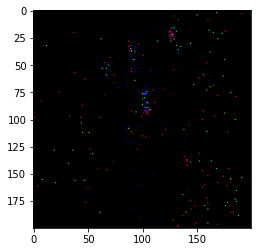

In [6]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


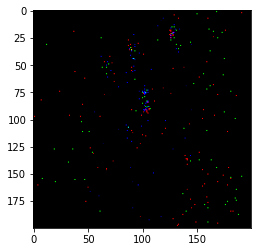

In [7]:
#Check augmentation
transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        #RandomRoll(1),
        RandomRoll(0)
)
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [8]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(device = device)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 200, 200])
tensor([[0.2780, 0.9142]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
training_results = train(resnet, train_data, test_data, 2**7, 5, RES, device, optimizer)

100%|██████████| 5/5 [09:51<00:00, 118.38s/it]


<AxesSubplot:xlabel='Iteration'>

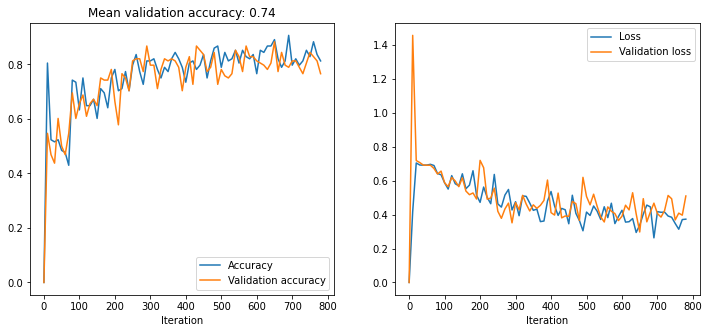

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)

In [11]:
truth, preds = predict(resnet, test_data, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 60/60 [00:08<00:00,  7.06it/s]


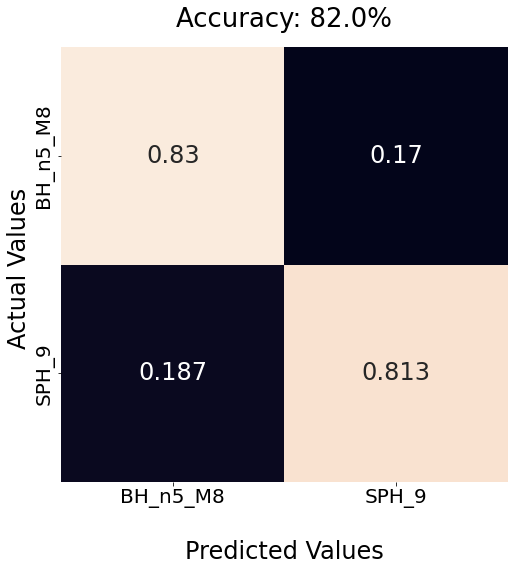

In [12]:
plot_conf_matrix(confusion, accuracy, LABELS)